In [1]:
# GAN Used for predicting seismic data as part of Direct Diffraction Separation with Genarative Adversarial Networks
# Code by Brydon Lowney (2020)
# GAN portion of code was written with aid from machinelearningmastery.com

In [15]:
# Import modules used 
import numpy as np
import os
import datetime
import segpy as spy
import imageio
import matplotlib.pyplot as plt
from segpy.reader import create_reader
from segpy.writer import write_segy
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from PIL import Image


In [88]:
# Define parameters

SEGYFILENAME  = '/home/addmin/machine_learning_dir/GAN_Git/SEISMIC/WR332a-stack.sgy' # Put in your input prediction segyfilename here
IMAGEDIR = '/home/addmin/machine_learning_dir/GAN_Git/IMAGES/' # Put your desired image directory here make sure it ends in a /
MODEL = '/home/addmin/machine_learning_dir/GAN_Git/MODELS/model_475000.h5' # Put desired model here (with path)

In [10]:
# Load the prediction data 

with open(SEGYFILENAME,'rb') as pre_in_file:
    
    t0 = datetime.datetime.now()
    
    pre_segy_dataset = create_reader(pre_in_file, endian='>')
    
    t1 = datetime.datetime.now()
    
    pretracefull = []
    
    for trace_index in pre_segy_dataset.trace_indexes():
        pretrace = pre_segy_dataset.trace_samples(trace_index)
        pretracetemp = []
        for n in range(0,len(pretrace)):
            temp = float(pretrace[n])
            pretracetemp.append(temp)
        pretracefull.append(pretracetemp)
    
    t2 = datetime.datetime.now()

In [11]:
# Check time to load 

time_for_header = (t1-t0).total_seconds()
time_for_traces = (t2-t1).total_seconds()
time_for_both = (t2-t0).total_seconds()

print('Time to read headers: {} seconds'.format(time_for_header))
print('Time to read traces: {} seconds'.format(time_for_traces))
print('Time to read both: {} seconds'.format(time_for_both))

Time to read headers: 0.30859 seconds
Time to read traces: 75.52617 seconds
Time to read both: 75.83476 seconds


In [12]:
# Convert the seismic to numpy array and rotate if necessary

pretracefull = np.array(pretracefull)

print(pretracefull.shape)

pretracefull = np.rot90(pretracefull, 3)

print(pretracefull.shape)

(4896, 5500)
(5500, 4896)


In [13]:
# Make the size divisible by 256 so we don't lose any data 

seismic_size = pretracefull.shape
seismic_y = seismic_size[0]
seismic_x = seismic_size[1]

mult_y = np.ceil(seismic_y/256)
mult_x = np.ceil(seismic_x/256) # ceiling is used so it always rounds up

mult_y = int(mult_y)
mult_x = int(mult_x)

new_y = mult_y*256
new_x = mult_x*256

newseismic = np.zeros((new_y,new_x))
newseismic[0:seismic_y,0:seismic_x] = pretracefull

print(seismic_size)
print(np.shape(newseismic))

(5500, 4896)
(5632, 5120)


In [19]:
# Make directories for the 256 x 256 size data for testing and save

predictdir = os.path.join(IMAGEDIR,'predict/')

if not os.path.exists(predictdir):
    os.mkdir(predictdir)

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        tra_256 = newseismic[y:y+256,x:x+256] 

        filenumber_y = str(y)
        filenumber_x = str(x)

        plt.imsave('{}predict_y{}_x{}.png'.format(predictdir, filenumber_y.zfill(5), filenumber_x.zfill(5)), tra_256, vmin=-5, vmax=5, cmap='Greys')


In [93]:
# Reload seismic but as an image 

pre_filelist = []

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)

        pre_filelist.append('{}predict_y{}_x{}.png'.format(predictdir, filenumber_y.zfill(5), filenumber_x.zfill(5)))
        
pre_images = np.array([np.array(Image.open(fname)) for fname in pre_filelist])

pre_images = pre_images[:,:,:,0:3]

np.shape(pre_images)

pre_images = (pre_images - 127.5) / 127.5


In [94]:
# load model

model = load_model(MODEL)

# generate image from source

gen_images = model.predict(pre_images)

1.0


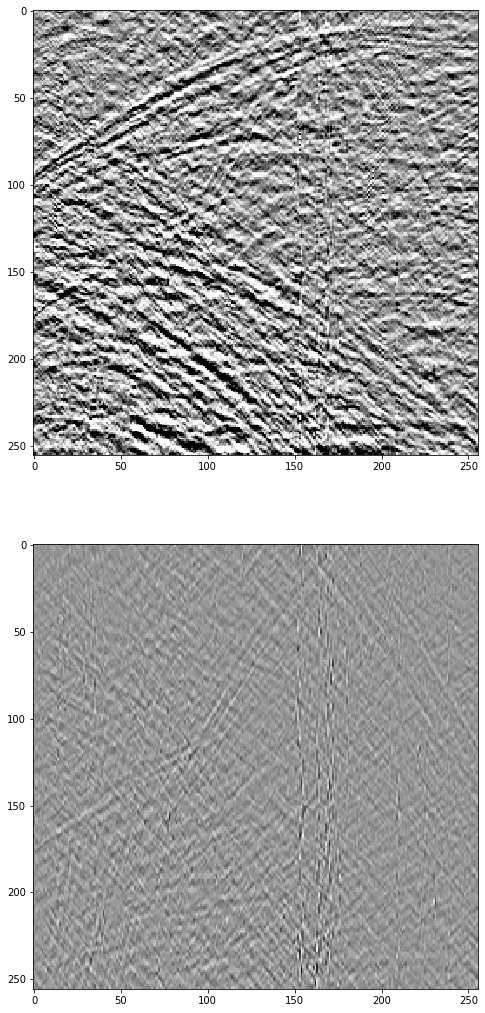

In [96]:
# Recalculate amplitudes so it fits on an RGB scale (0:1)

gen_img_plot = (gen_images + 1) / 2
pre_img_plot = (pre_images + 1) / 2 

print(np.max(pre_images))

fig, axes = pyplot.subplots(2, 1, figsize=(18, 18))
axes[0].imshow(pre_img_plot[210], cmap='Greys')
axes[1].imshow(gen_img_plot[210], cmap='Greys')

In [97]:
# Save the generated images

i = 0

gendir = os.path.join(IMAGEDIR,'generated/')

if not os.path.exists(gendir):
    os.mkdir(gendir)

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)
               
        pyplot.imsave('{}generated_y{}_x{}.png'.format(gendir,filenumber_y.zfill(5), filenumber_x.zfill(5)), gen_img_plot[i], vmin=-500, vmax=500, cmap='Greys')
        
        i = i+1        